In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers

2024-05-20 06:20:49.108418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 06:20:49.108544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 06:20:49.268186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 

In [4]:
# This has good code on how to load the image and mask pairs but not so good code for making 
# and training model and he used paths to images
# https://www.kaggle.com/code/cheesecke/image-segmentation

images_path = "/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images"
masks_path = "/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/masks"

# Extracting all the file names 
file_names = os.listdir(images_path)
file_names[:5]
# As the file names for both images and masks are exactly same here so we don't need mask file names

# Bonus - if the file names were slightly different we could have extracted and modified and then 
# matched accordingly in the next step 

['653_00120.png',
 '229_00180.png',
 '298_00330.png',
 '7_00240.png',
 '456_00180.png']

In [5]:
# Image loader and preprocessing function 
# This can load a single image-mask pair 

def load_image(image_path, mask_path):
    image, mask = tf.io.read_file(image_path), tf.io.read_file(mask_path)
    image, mask = tf.image.decode_png(image), tf.image.decode_png(mask)
    image, mask = tf.cast(image, tf.float32), tf.cast(mask, tf.float32)
    image, mask = tf.image.resize(image, (224,224)), tf.image.resize(mask, (224,224))
    image, mask = image/255, mask/255
    # Add batch dimension
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)
    return image, mask

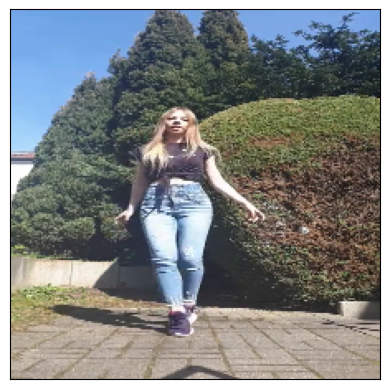

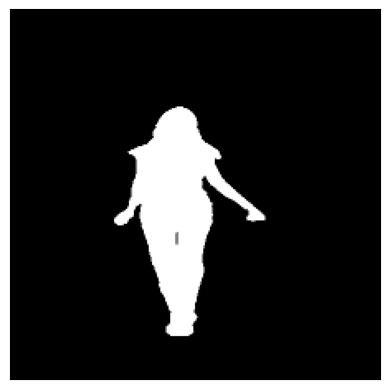

In [6]:
# Just seeing a image-mask pair to check whether its loaded correctly or not 

# Note that if the file names were slightly different we could have worked it out here 
image1, mask1 = load_image(os.path.join(images_path, file_names[-1]), os.path.join(masks_path, file_names[-1]))

# plt.figure(figsize=(3,3)) not working idk y 

plt.xticks([])
plt.yticks([])
plt.imshow(tf.squeeze(image1, axis=0))
plt.show()

plt.xticks([])
plt.yticks([])
plt.imshow(tf.squeeze(mask1, axis=0))
plt.show()

In [7]:
# images = []
# masks = []

# temp_img = []
# temp_mask = []

# for path in file_names:
#     temp_img,temp_mask = load_image(os.path.join(images_path,path), os.path.join(masks_path,path))
#     images.append(temp_img)
#     masks.append(temp_mask)
    
# print(len(images))
# print(len(masks))
# print(images[0].shape)
# print(masks[0].shape)

# Output after like 5 minutes 
# 2615
# 2615
# (224, 224, 3)
# (224, 224, 3)

# Code crashy kinda which makes sense cause memory overflow
# The tricks I learnt while training simple models like CNN wont be useful here 
# So basically I have to call the images one by one 

In [8]:
images = np.array([os.path.join(images_path, x) for x in file_names])
masks = np.array([os.path.join(masks_path, x) for x in file_names])
print(images.shape, masks.shape)

(2615,) (2615,)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print(X_train[:5])
print()
print(Y_train[:5])

# Now we have an array of paths of image-mask pairs split into train-test

(2092,) (2092,)
(523,) (523,)
['/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images/607_00060.png'
 '/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images/630_00390.png'
 '/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images/533_00150.png'
 '/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images/367_00300.png'
 '/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/images/591_00150.png']

['/kaggle/input/segmentation-full-body-tiktok-dancing-dataset/segmentation_full_body_tik_tok_2615_img/segmentation_full_body_tik_tok_2615_img/masks/

In [10]:
# Docs - https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# This is used for datasets in tensorflow when whole thing won't fit in RAM 
# Even docs recommend using map 

training_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# Need to shuffle to avoid overfitting 
training_dataset = training_dataset.shuffle(1000)
# map is used to apply a function (here image loader function) on all elements
training_dataset = training_dataset.map(load_image) #.batch(130)


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
# In test we do not need to shuffle or batch
test_dataset = test_dataset.map(load_image) # .batch(1)

# https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/
# Now like this we will feed these batched datasets into model.fit and train the model 

# https://www.kaggle.com/code/cheesecke/image-segmentation
# This has used gradienttape method to train the model which is not suitable to me 

In [11]:
print(training_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(1, 224, 224, None), dtype=tf.float32, name=None), TensorSpec(shape=(1, 224, 224, None), dtype=tf.float32, name=None))>


In [12]:
# Original UNet ka research paper - see structure which we have to implement
# https://arxiv.org/pdf/1505.04597v1

# 3 ways to make model in tensorflow
# https://pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/
# UNet cannot be made using sequential modelling so we have to use functional modelling in tensorflow 

# Docs for tensorflow functional API 
# https://www.tensorflow.org/guide/keras/functional_api

In [13]:
# Very well explained code for UNet coding in tensorflow
# https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/


def downsample_block(x, n_filters):
   # Conv2D then ReLU activation
   # He initialization being used for relu to avoid vanishing/exploding gradient
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   f = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # This f will go ahead straight, and now we pool to send to next part of shrinking layer
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate - Note how we concatenate the "where" information coming from the shrinking path
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation - size remains same here 
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [14]:
 def build_unet_model():
    # inputs
   inputs = layers.Input(shape=(224,224,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(filters=1,kernel_size=1, padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

# Chatgpt + docs explanation for output layer structure - 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# Since you have 2 classes (human and not human), your output layer should have 2 filters with softmax
# In binary segmentation, we only need 1 filter if we're using the sigmoid activation function, 
# as it outputs a single probability value indicating the likelihood of the pixel being in the "human" class.

In [15]:
unet_model = build_unet_model()

In [16]:
def weighted_binary_crossentropy(y_true, y_pred, weights):
    bce = tf.keras.losses.BinaryCrossentropy()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Calculate the binary cross-entropy loss
    loss = bce(y_true, y_pred)
    # Apply class weights
    weighted_loss = loss * weights
    return tf.reduce_mean(weighted_loss)

def custom_loss(y_true, y_pred):
    # Weigh background (0) less and foreground (1) more
    class_weights = tf.constant([1.0, 5.0])
    weights = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
    return weighted_binary_crossentropy(y_true, y_pred, weights)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=custom_loss,  # tf.keras.losses.BinaryCrossentropy(),  #keras.metrics.BinaryIoU,
                  metrics=[tf.keras.metrics.BinaryAccuracy()])

# Binary cross entropy is same as log loss which is used in logistic regression / 2 class problems 
# Otherwise for multiple classes we would use sparse_categorical_crossentropy I think 

In [17]:
# pip install graphviz pydot

In [18]:
# Given in docs that it should print the ml model ka graph 
# (keras.utils.plot_model(unet_model, "unet_model.png", show_shapes=True))
# The image is too big and annoying to scroll so better keep this commented 
# Can see the automatically downloaded png image also 


In [19]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 14, 14,    │          0 │ max_pooling2d_3[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
NUM_EPOCHS = 10
# TRAIN_LENGTH = info.splits["train"].num_examples
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
# VAL_SUBSPLITS = 5
# TEST_LENTH = info.splits["test"].num_examples
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

callback = keras.callbacks.EarlyStopping(monitor='binary_accuracy',
                                              patience=2,min_delta=0.005)

model_history = unet_model.fit(training_dataset,
                              epochs=NUM_EPOCHS,
                              validation_data=test_dataset,
                              batch_size=50,
                              callbacks=[callback])
#                               class_weight = {0:1, 1:5})

#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,

Epoch 1/10
   1/2092 ━━━━━━━━━━━━━━━━━━━━ 24:42:33 43s/step - binary_accuracy: 0.2691 - loss: 1.1038

I0000 00:00:1716186104.674725     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2092/2092 ━━━━━━━━━━━━━━━━━━━━ 199s 75ms/step - binary_accuracy: 0.8964 - loss: 0.4370 - val_binary_accuracy: 0.9117 - val_loss: 0.2931
Epoch 2/10
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - binary_accuracy: 0.9130 - loss: 0.3025 - val_binary_accuracy: 0.9246 - val_loss: 0.2470
Epoch 3/10
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 202s 75ms/step - binary_accuracy: 0.9255 - loss: 0.2620 - val_binary_accuracy: 0.9223 - val_loss: 0.2627
Epoch 4/10
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - binary_accuracy: 0.9343 - loss: 0.2365 - val_binary_accuracy: 0.9414 - val_loss: 0.2091
Epoch 5/10
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - binary_accuracy: 0.9383 - loss: 0.2228 - val_binary_accuracy: 0.9300 - val_loss: 0.2438
Epoch 6/10
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 156s 75ms/step - binary_accuracy: 0.9382 - loss: 0.2182 - val_binary_accuracy: 0.9488 - val_loss: 0.1847
Epoch 7/10
2092/2092 ━━━━━━━━━━━━━━━━━━━━ 157s 75ms/step - binary_accuracy: 0.9440 - loss: 0.1998 - val_binary_accuracy: 0.9514 -

In [21]:
# todo 
# to introduce callbacks to automatically stop training if the accuracy isnt increasing much 

In [22]:
# acc = model_history.history['binary_accuracy']
# val_acc = model_history.history['val_binary_accuracy']

# loss = model_history.history['loss']
# val_loss = model_history.history['val_loss']

# epochs = 3 # was meant to be defined above but we directly wrote 10 there so defining here
# epochs_range = range(epochs)

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(range(len(acc)), acc, label='Training Accuracy')
# plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()




In [23]:
# https://www.kaggle.com/code/nicholasdunham/saving-and-persisting-data-in-kaggle
# Need to change persistance settings while saving notebook , and then check output tab for the 
# files (model weights in my case bcoz I can't wait 30 min again )

In [30]:
unet_model.save('unet_model_people_segmenter.keras')


In [31]:
unet_model.save('unet_model_people_segmenter.h5')

In [25]:
# https://www.tensorflow.org/tutorials/keras/save_and_load
# saved_model = tf.keras.models.load_model('/kaggle/input/human_segmentation_unet_1/keras/unet_model/1.keras', compile=False)



# Show the model architecture
# saved_model.summary()

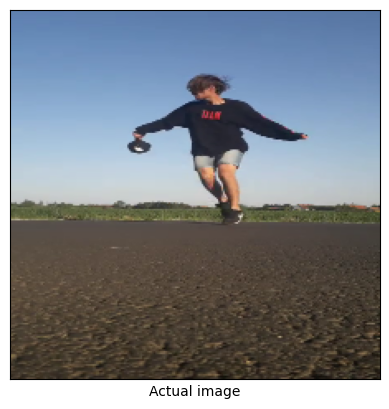

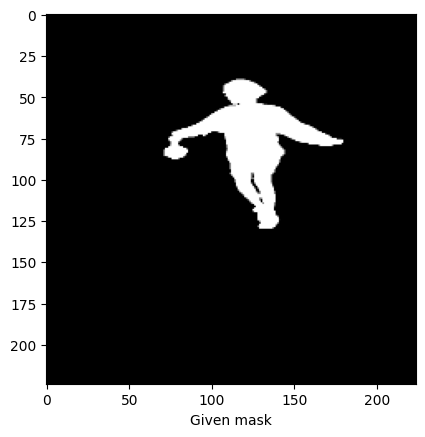

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


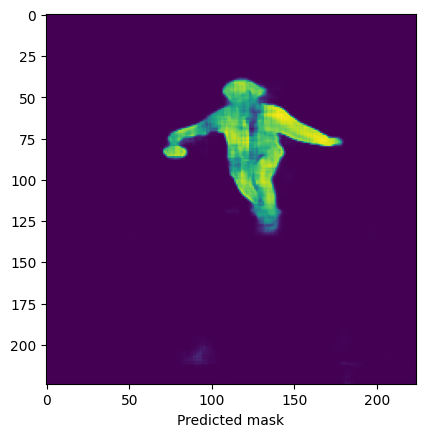

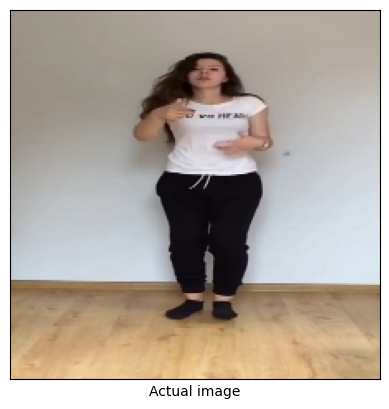

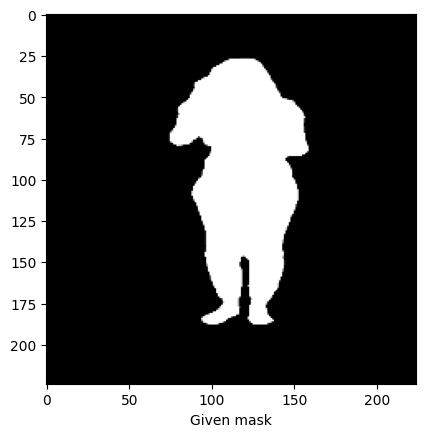

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


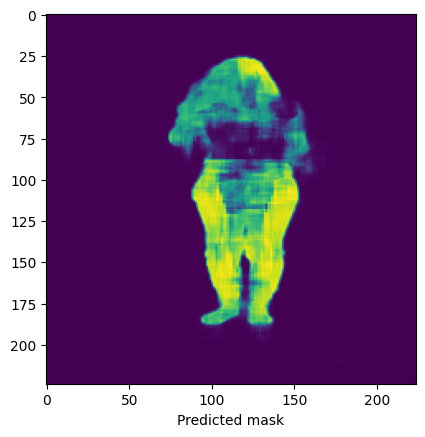

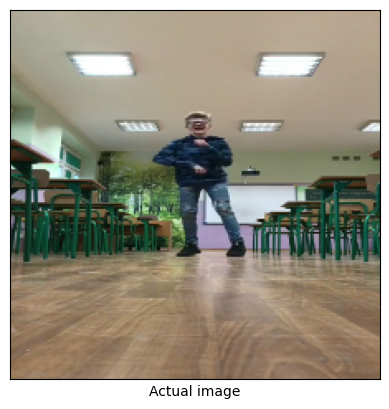

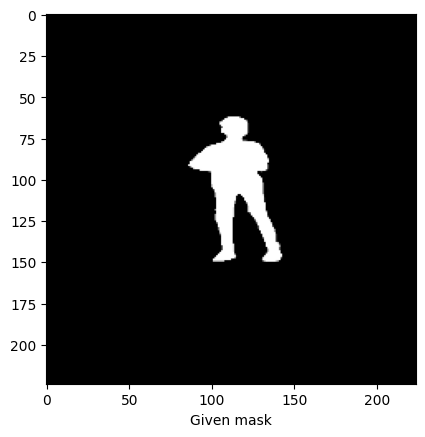

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


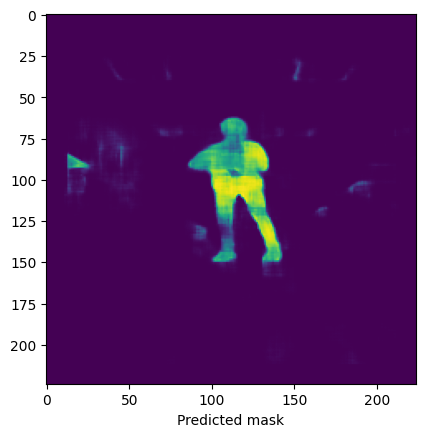

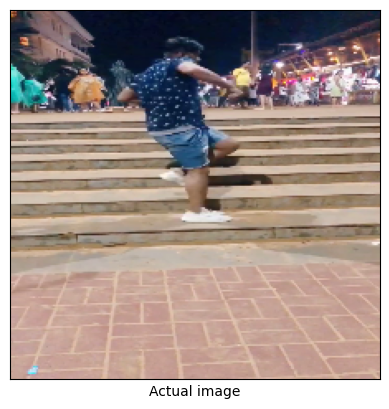

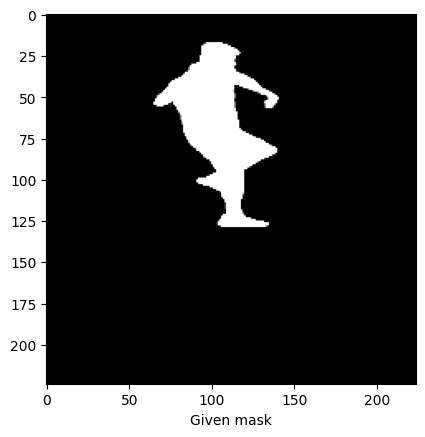

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


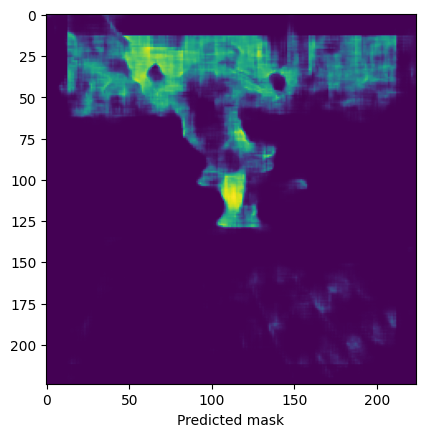

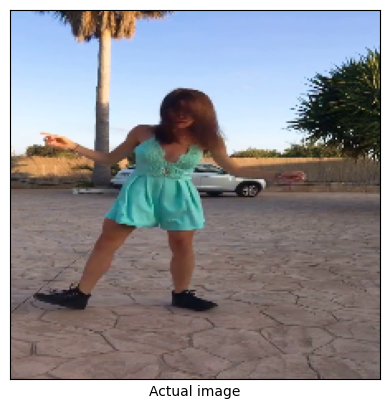

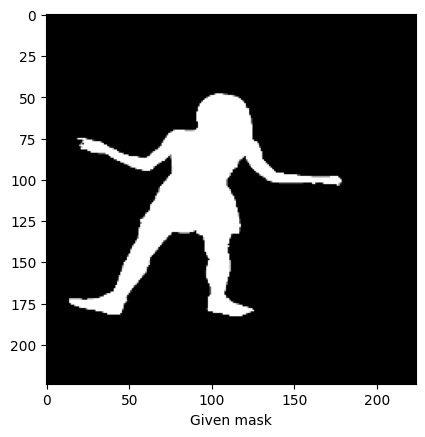

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


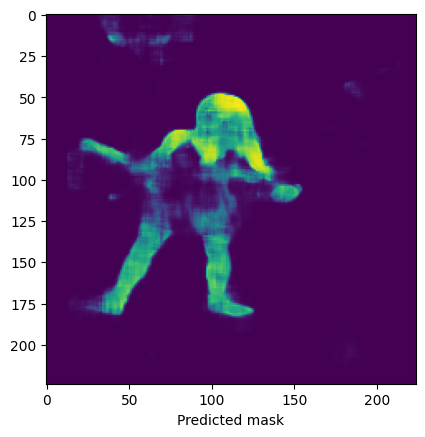

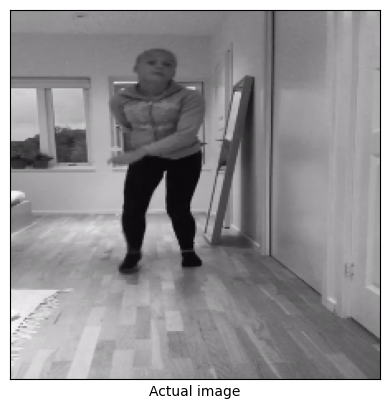

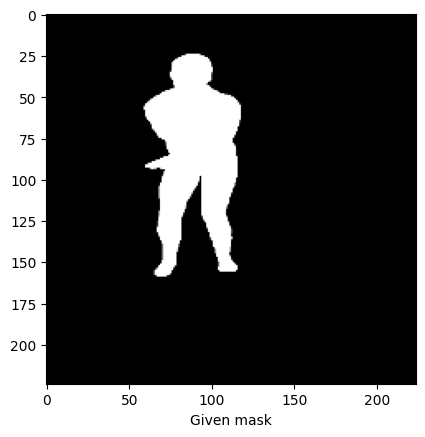

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


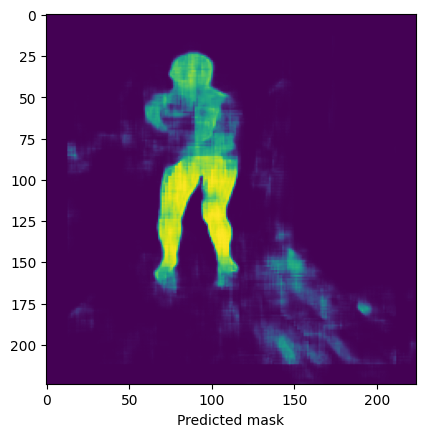

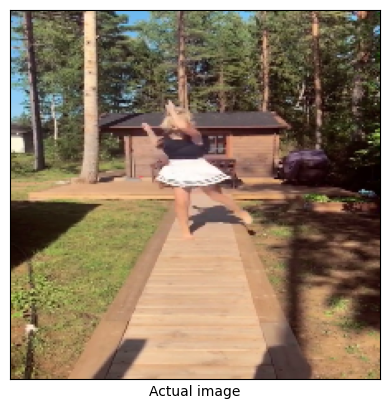

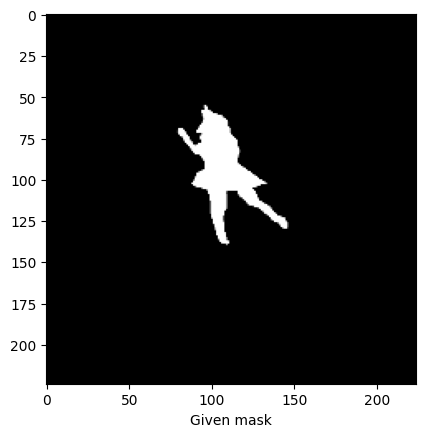

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


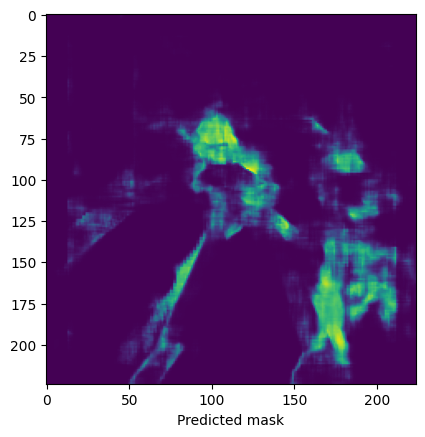

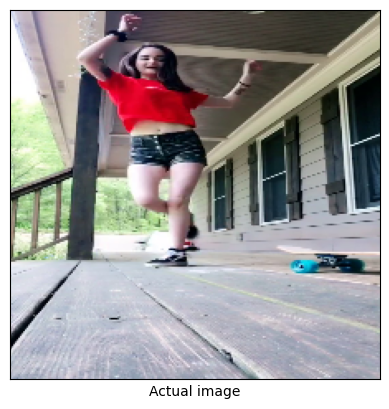

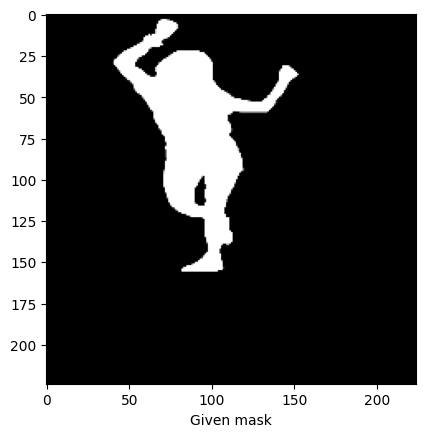

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


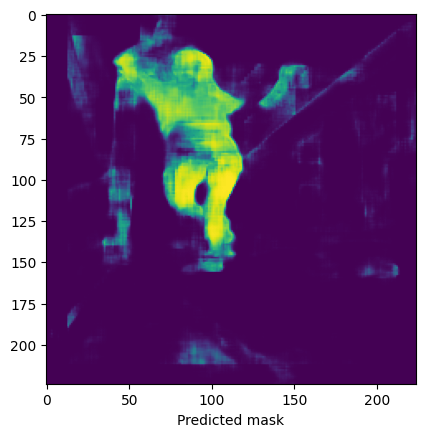

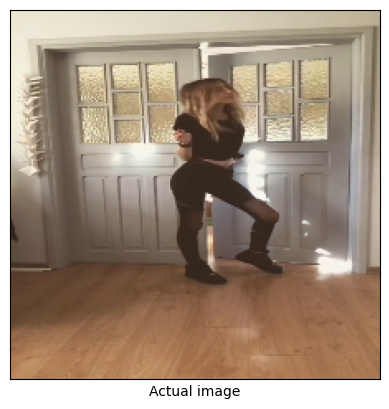

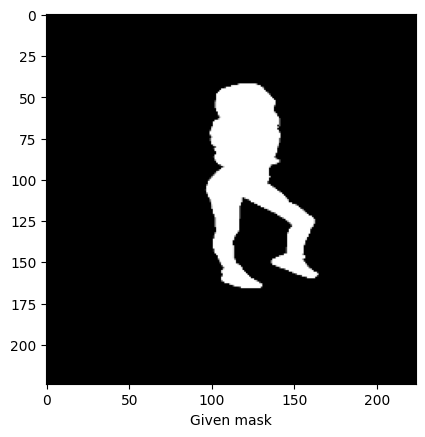

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


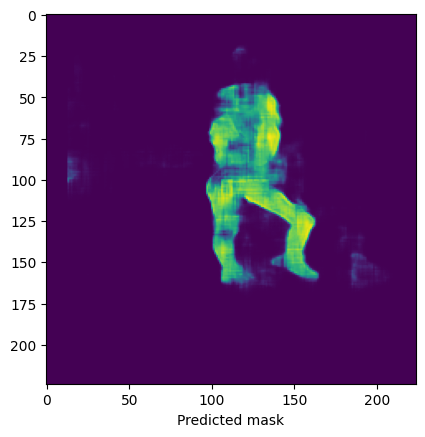

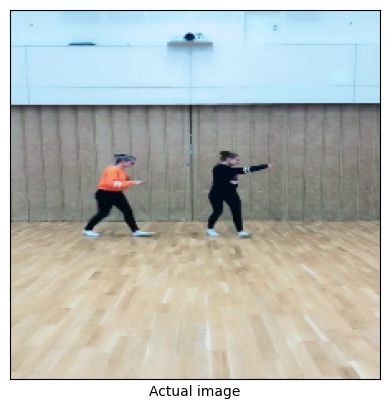

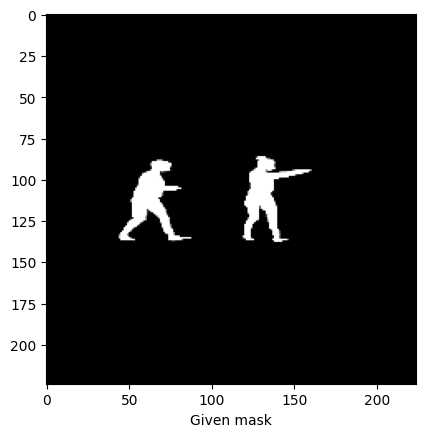

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


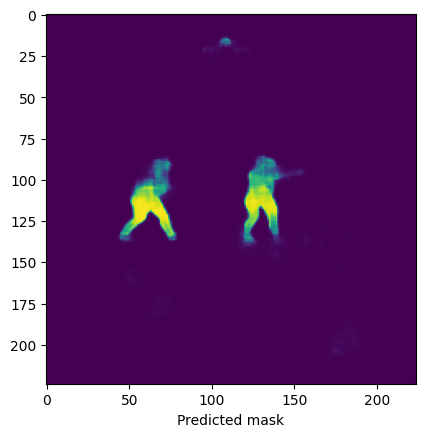

In [36]:


# plt.figure(figsize=(10,12))
rand_pics = np.random.randint(low=0, high=2000, size=10)

for i in range(10):
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
    # plt.subplot(5,3,i+1)
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
    # we can set x and y labels in a plot
    image1, mask1 = load_image(os.path.join(images_path, file_names[rand_pics[i]]), os.path.join(masks_path, file_names[rand_pics[i]]))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tf.squeeze(image1, axis=0)) # , cmap=plt.cm.binary
    plt.xlabel("Actual image")
    plt.show()
    # plt.ylabel(class_names[np.argmax(predictions[i])])
    plt.imshow(tf.squeeze(mask1, axis=0))
    plt.xlabel("Given mask")
    plt.show()
    prediction = unet_model.predict(image1)
    plt.imshow(tf.squeeze(prediction, axis=0))
    plt.xlabel("Predicted mask")
    plt.show()
plt.show()

# image1, mask1 = load_image(os.path.join(images_path, file_names[-1]), os.path.join(masks_path, file_names[-1]))
# plt.xticks([])
# plt.yticks([])
# plt.imshow(tf.squeeze(image1, axis=0))
# plt.show()

# plt.xticks([])
# plt.yticks([])
# plt.imshow(tf.squeeze(mask1, axis=0))
# plt.show()